The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


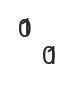

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette, plot_loss_aucs
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.models import *
from src.torch_utils import save_checkpoint, load_checkpoint
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
mpl.rcParams['figure.dpi'] = 180

In [5]:
pkl_load(CSL_hp_2hl_wd1e-4_bs256_all_KFold_1_231125_1045_None/valid_losses_kcv_train_all5_correct_f01_CSL_hp_2hl_wd1e-4_bs256_all_KFold_1_231125_1045_None.pkl')

In [11]:
no_dropout = [x for x in sorted(os.listdir('../../dropout_comparison/no_dropout/')) if 'DS_Sto' not in x]

In [93]:
no_drop = '../../dropout_comparison/no_dropout/'
no_drop_folders = [os.path.join(no_drop, z) for z in filter(lambda x: 'DS_St' not in x, os.listdir(no_drop))]
w_drop = '../../dropout_comparison/with_dropout/'
w_drop_folders = [os.path.join(w_drop, z) for z in filter(lambda x: 'DS_St' not in x, os.listdir(w_drop))]

In [111]:
w_drop_folders, no_drop_folders

(['../../dropout_comparison/with_dropout/CSL_hp_2hl_wd1e-4_bs256_do0.3_all_KFold_1_231127_1530_None',
  '../../dropout_comparison/with_dropout/CSL_hp_2hl_wd1e-4_bs256_do0.3_all_KFold_4_231127_1955_None',
  '../../dropout_comparison/with_dropout/CSL_hp_2hl_wd1e-4_bs256_do0.3_all_KFold_2_231127_1659_None',
  '../../dropout_comparison/with_dropout/CSL_hp_2hl_wd1e-4_bs256_do0.3_all_KFold_5_231127_2115_None',
  '../../dropout_comparison/with_dropout/CSL_hp_2hl_wd1e-4_bs256_do0.3_all_KFold_3_231127_1835_None'],
 ['../../dropout_comparison/no_dropout/CSL_hp_2hl_wd1e-4_bs256_all_KFold_3_231125_1402_None',
  '../../dropout_comparison/no_dropout/CSL_hp_2hl_wd1e-4_bs256_all_KFold_5_231125_1657_None',
  '../../dropout_comparison/no_dropout/CSL_hp_2hl_wd1e-4_bs256_all_KFold_4_231125_1541_None',
  '../../dropout_comparison/no_dropout/CSL_hp_2hl_wd1e-4_bs256_all_KFold_1_231125_1045_None',
  '../../dropout_comparison/no_dropout/CSL_hp_2hl_wd1e-4_bs256_all_KFold_2_231125_1231_None'])

In [134]:
def plot_fold(k):
    train_losses_no_drop = []
    train_aucs_no_drop = []
    valid_losses_no_drop = []
    valid_aucs_no_drop = []
    for folder in no_drop_folders:
        z = folder.split('KFold_')[1].split('_23')[0]
        if int(z)!=k:continue
        valid_loss = pkl_load(folder+'/'+next(filter(lambda x: 'valid_losses' in x, os.listdir(folder))))
        train_loss = pkl_load(folder+'/'+next(filter(lambda x: 'train_losses' in x, os.listdir(folder))))
        valid_aucs = get_dict_of_lists(pkl_load(folder+'/'+next(filter(lambda x: 'valid_metric' in x, os.listdir(folder)))), 'valid')['valid_auc']
        train_aucs = get_dict_of_lists(pkl_load(folder+'/'+next(filter(lambda x: 'train_metric' in x, os.listdir(folder)))), 'train')['train_auc']
        train_losses_no_drop.append(train_loss)
        train_aucs_no_drop.append(train_aucs)
        valid_losses_no_drop.append(valid_loss)
        valid_aucs_no_drop.append(valid_aucs)
    train_losses_w_drop = []
    train_aucs_w_drop = []
    valid_losses_w_drop = []
    valid_aucs_w_drop = []
    for folder in w_drop_folders:
        z = folder.split('KFold_')[1].split('_23')[0]
        if int(z)!=k:continue
        valid_loss = pkl_load(folder+'/'+next(filter(lambda x: 'valid_losses' in x, os.listdir(folder))))
        train_loss = pkl_load(folder+'/'+next(filter(lambda x: 'train_losses' in x, os.listdir(folder))))
        valid_aucs = get_dict_of_lists(pkl_load(folder+'/'+next(filter(lambda x: 'valid_metric' in x, os.listdir(folder)))), 'valid')['valid_auc']
        train_aucs = get_dict_of_lists(pkl_load(folder+'/'+next(filter(lambda x: 'train_metric' in x, os.listdir(folder)))), 'train')['train_auc']
        train_losses_w_drop.append(train_loss)
        train_aucs_w_drop.append(train_aucs)
        valid_losses_w_drop.append(valid_loss)
        valid_aucs_w_drop.append(valid_aucs)
    train_losses_no_drop = np.mean(train_losses_no_drop, axis=0)
    train_aucs_no_drop = np.mean(train_aucs_no_drop, axis=0)
    valid_losses_no_drop = np.mean(valid_losses_no_drop, axis=0)
    valid_aucs_no_drop = np.mean(valid_aucs_no_drop, axis=0)
    train_losses_w_drop = np.mean(train_losses_w_drop, axis=0)
    train_aucs_w_drop = np.mean(train_aucs_w_drop, axis=0)
    valid_losses_w_drop = np.mean(valid_losses_w_drop, axis=0)
    valid_aucs_w_drop = np.mean(valid_aucs_w_drop, axis=0)
    f,a = plt.subplots(2,2, figsize=(20,20))
    sns.set_palette(get_palette('gnuplot2', n_colors=4))
    a = a.ravel()
    
    for ax, plot, labels in zip(a, [[train_losses_no_drop, valid_losses_no_drop],
                                    [train_losses_w_drop, valid_losses_w_drop],
                                    [train_aucs_no_drop, valid_aucs_no_drop],
                                    [train_aucs_w_drop, valid_aucs_w_drop]],
                                [['train_loss_no_dropout', 'valid_loss_no_dropout'],
                               ['train_loss_with_dropout', 'valid_loss_with_dropout'],
                               ['train_aucs_no_dropout', 'valid_aucs_no_dropout'],
                               ['train_aucs_with_dropout', 'valid_aucs_with_dropout']]):
       
        ax.plot(plot[0], label=labels[0])
        ax.plot(plot[1], label=labels[1])
        ax.legend()
        if 'auc' in labels[0]:
            ax.set_ylim([0.85, 0.95])
        else:
            ax.set_ylim([0.02, 0.04])

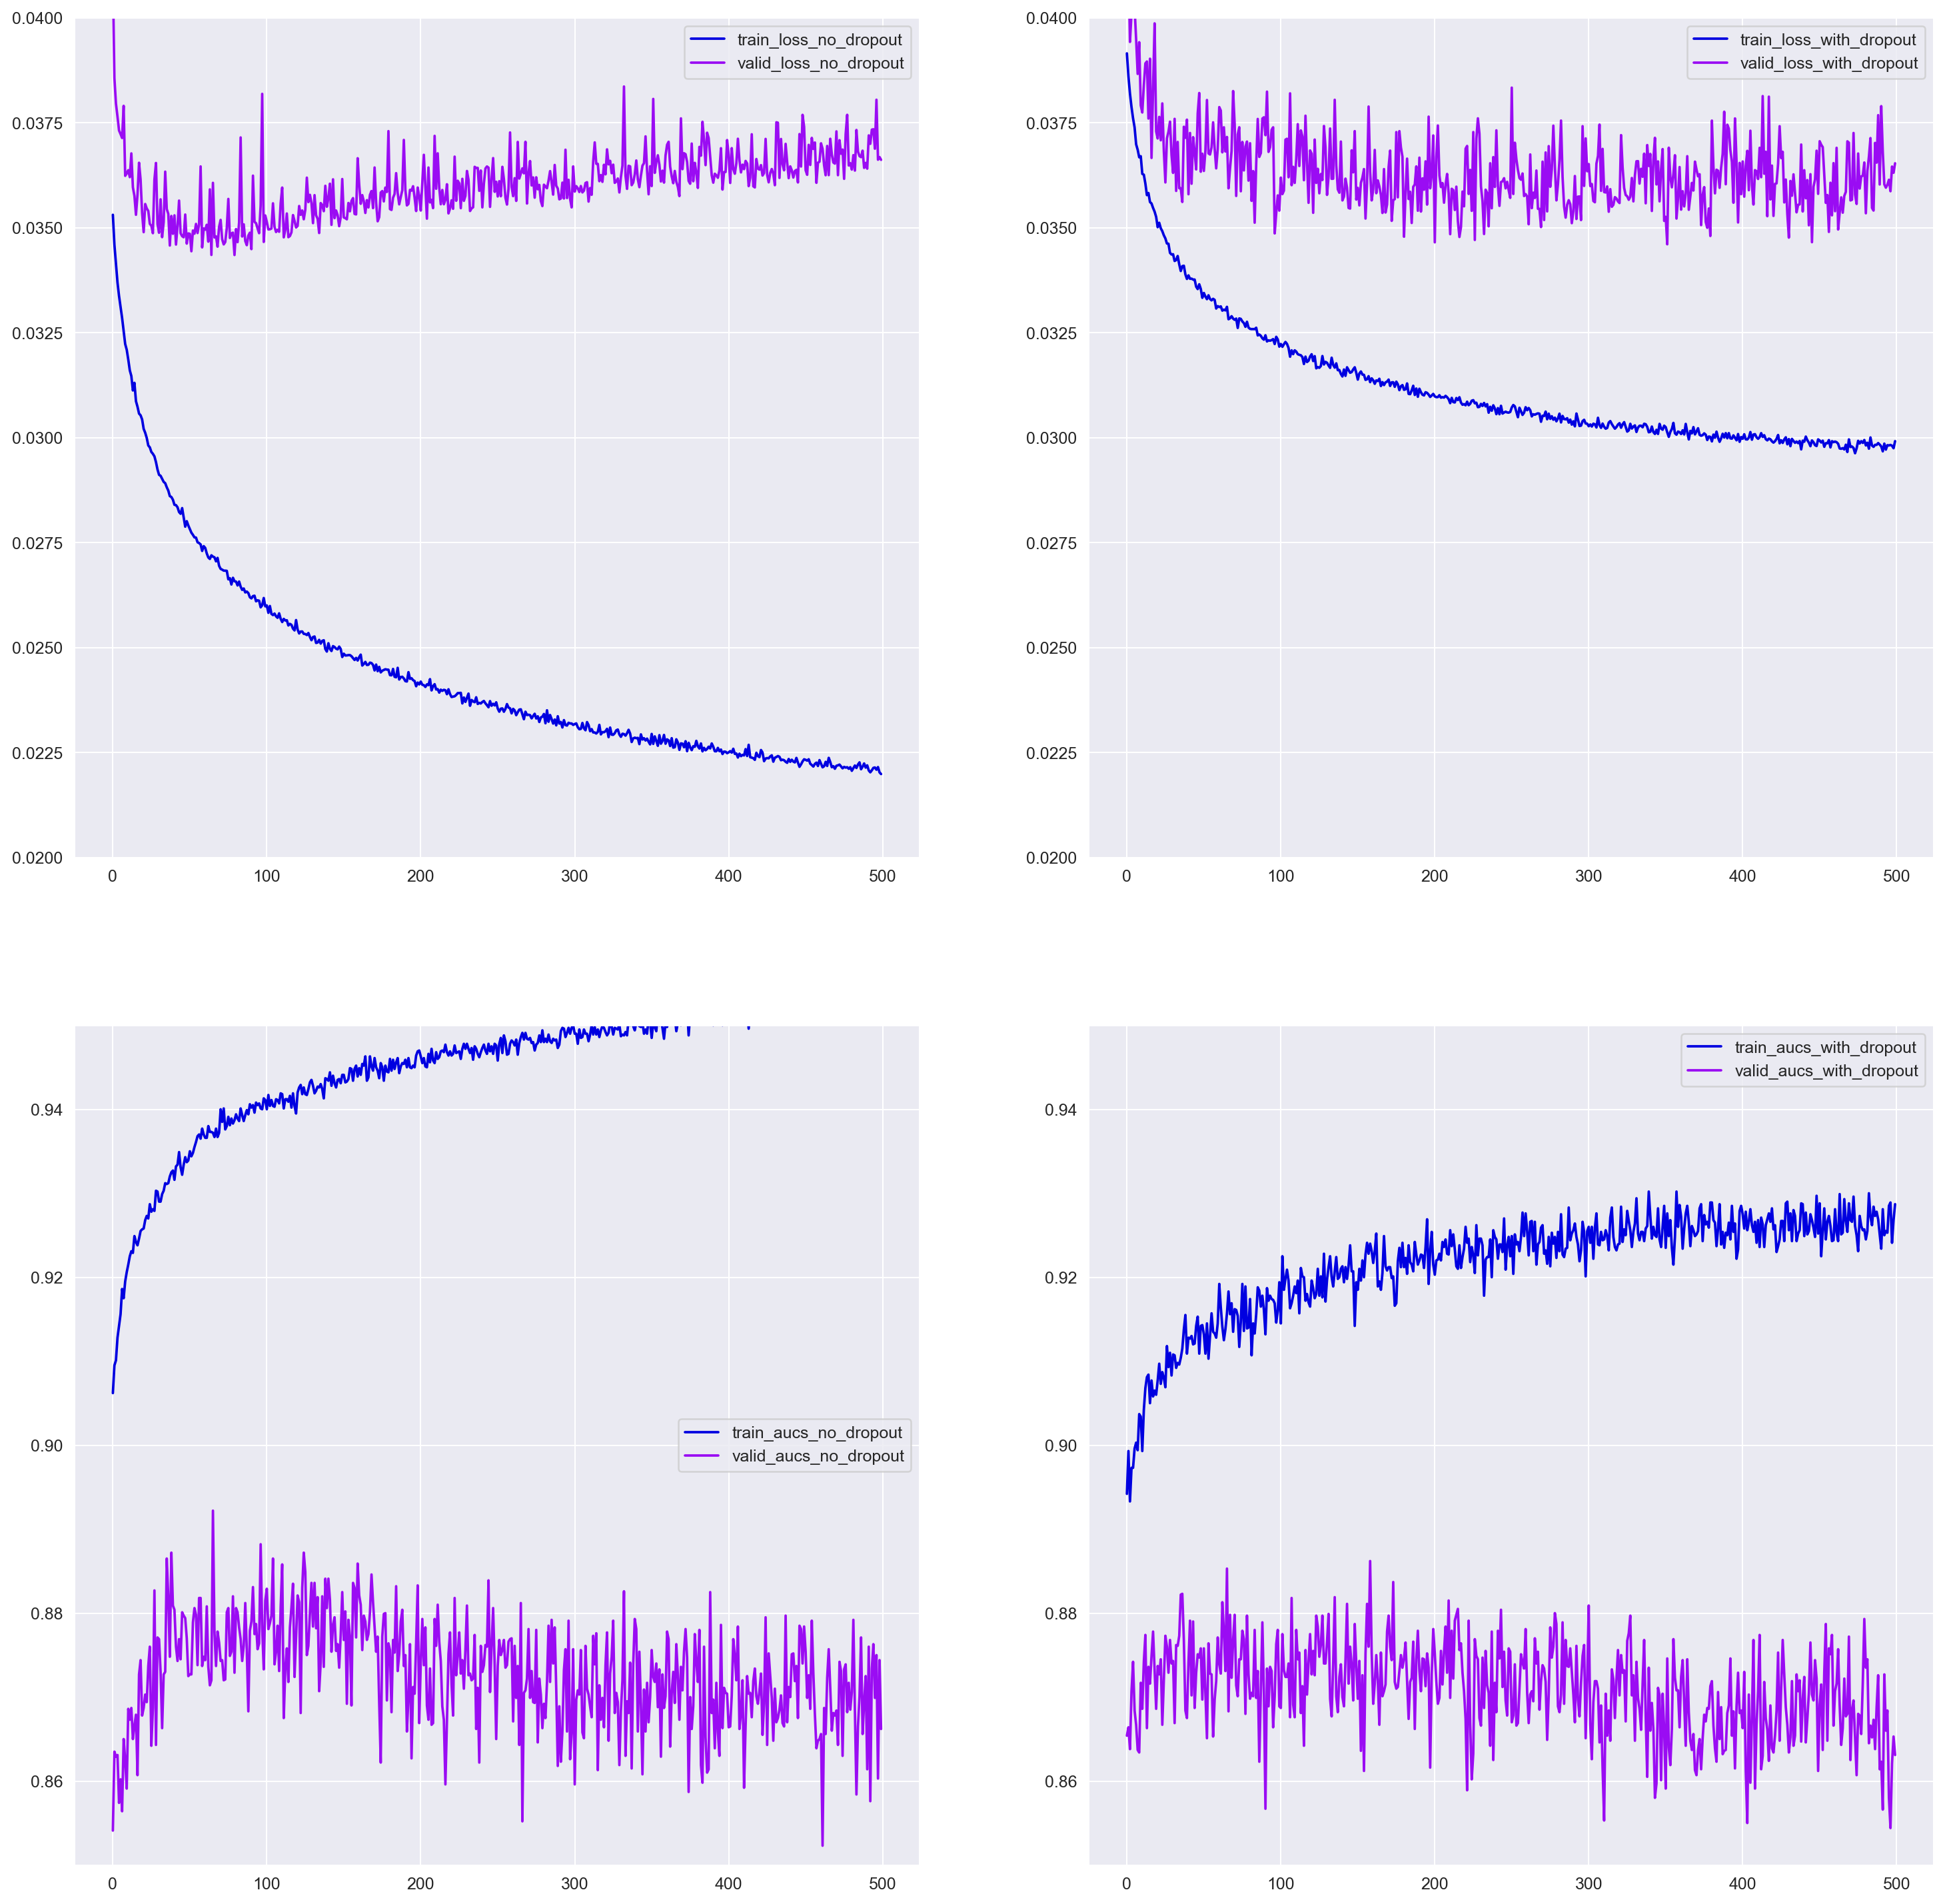

In [135]:
plot_fold(1)

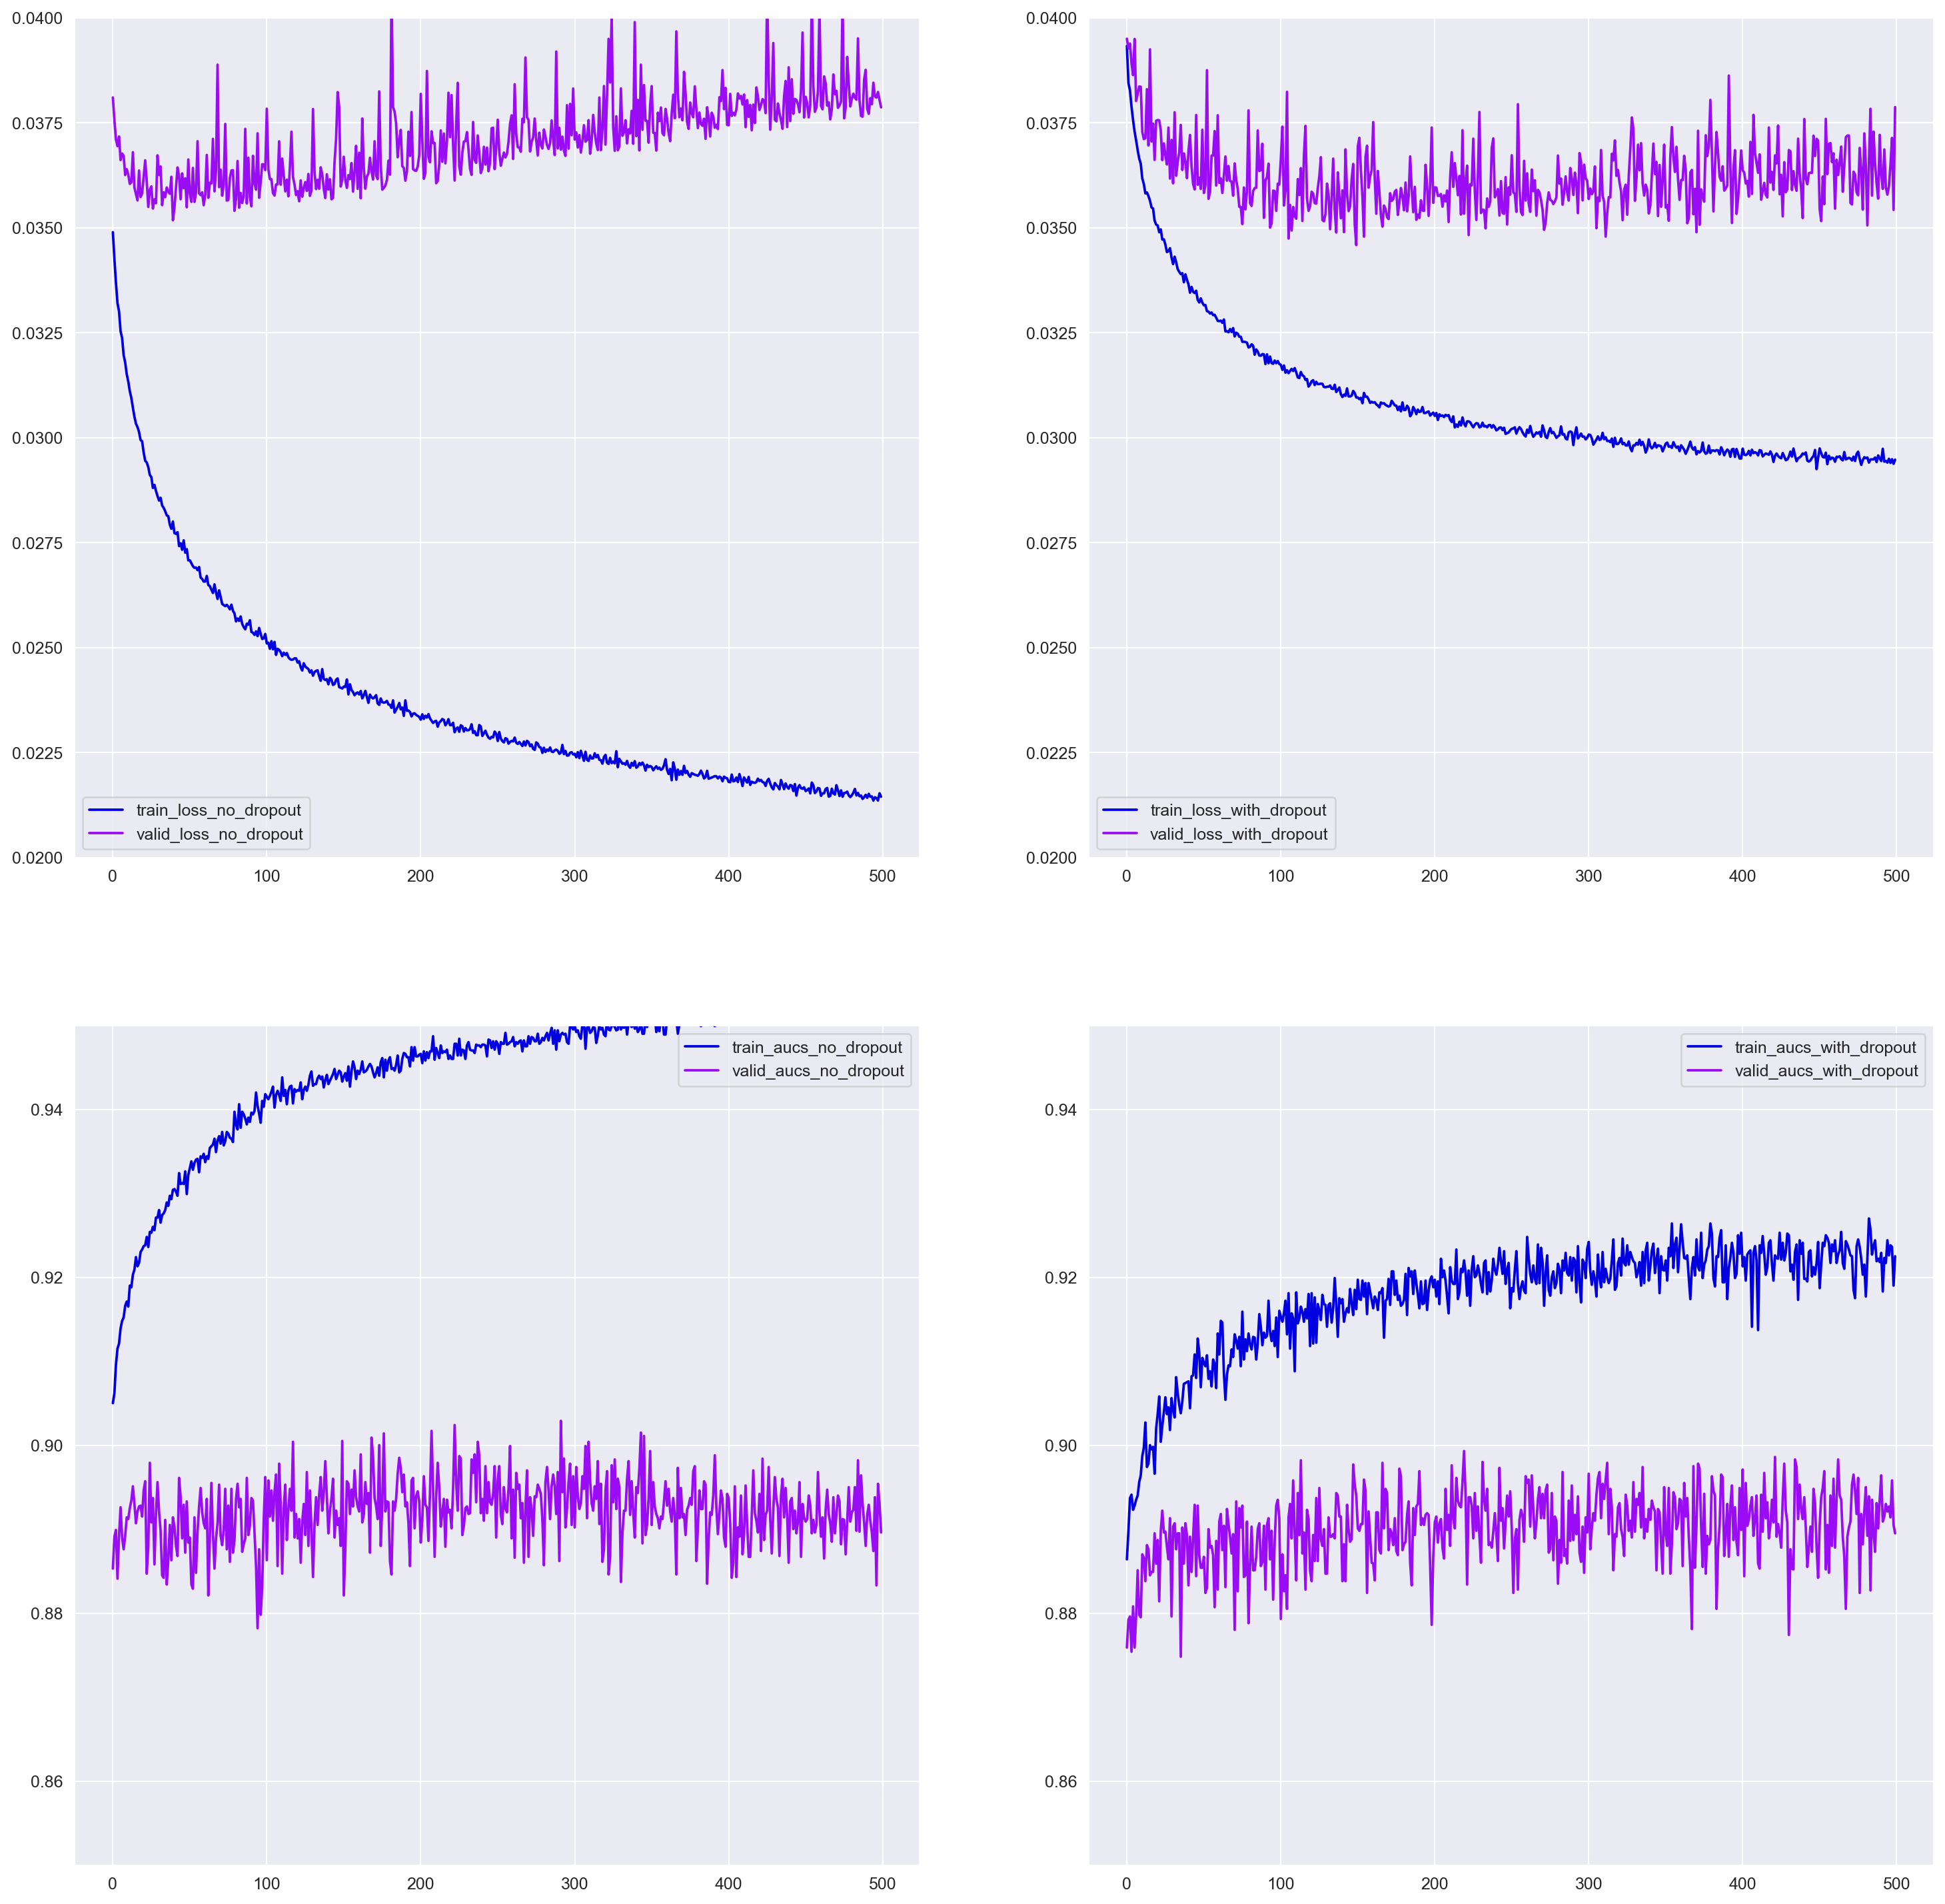

In [140]:
plot_fold(2)

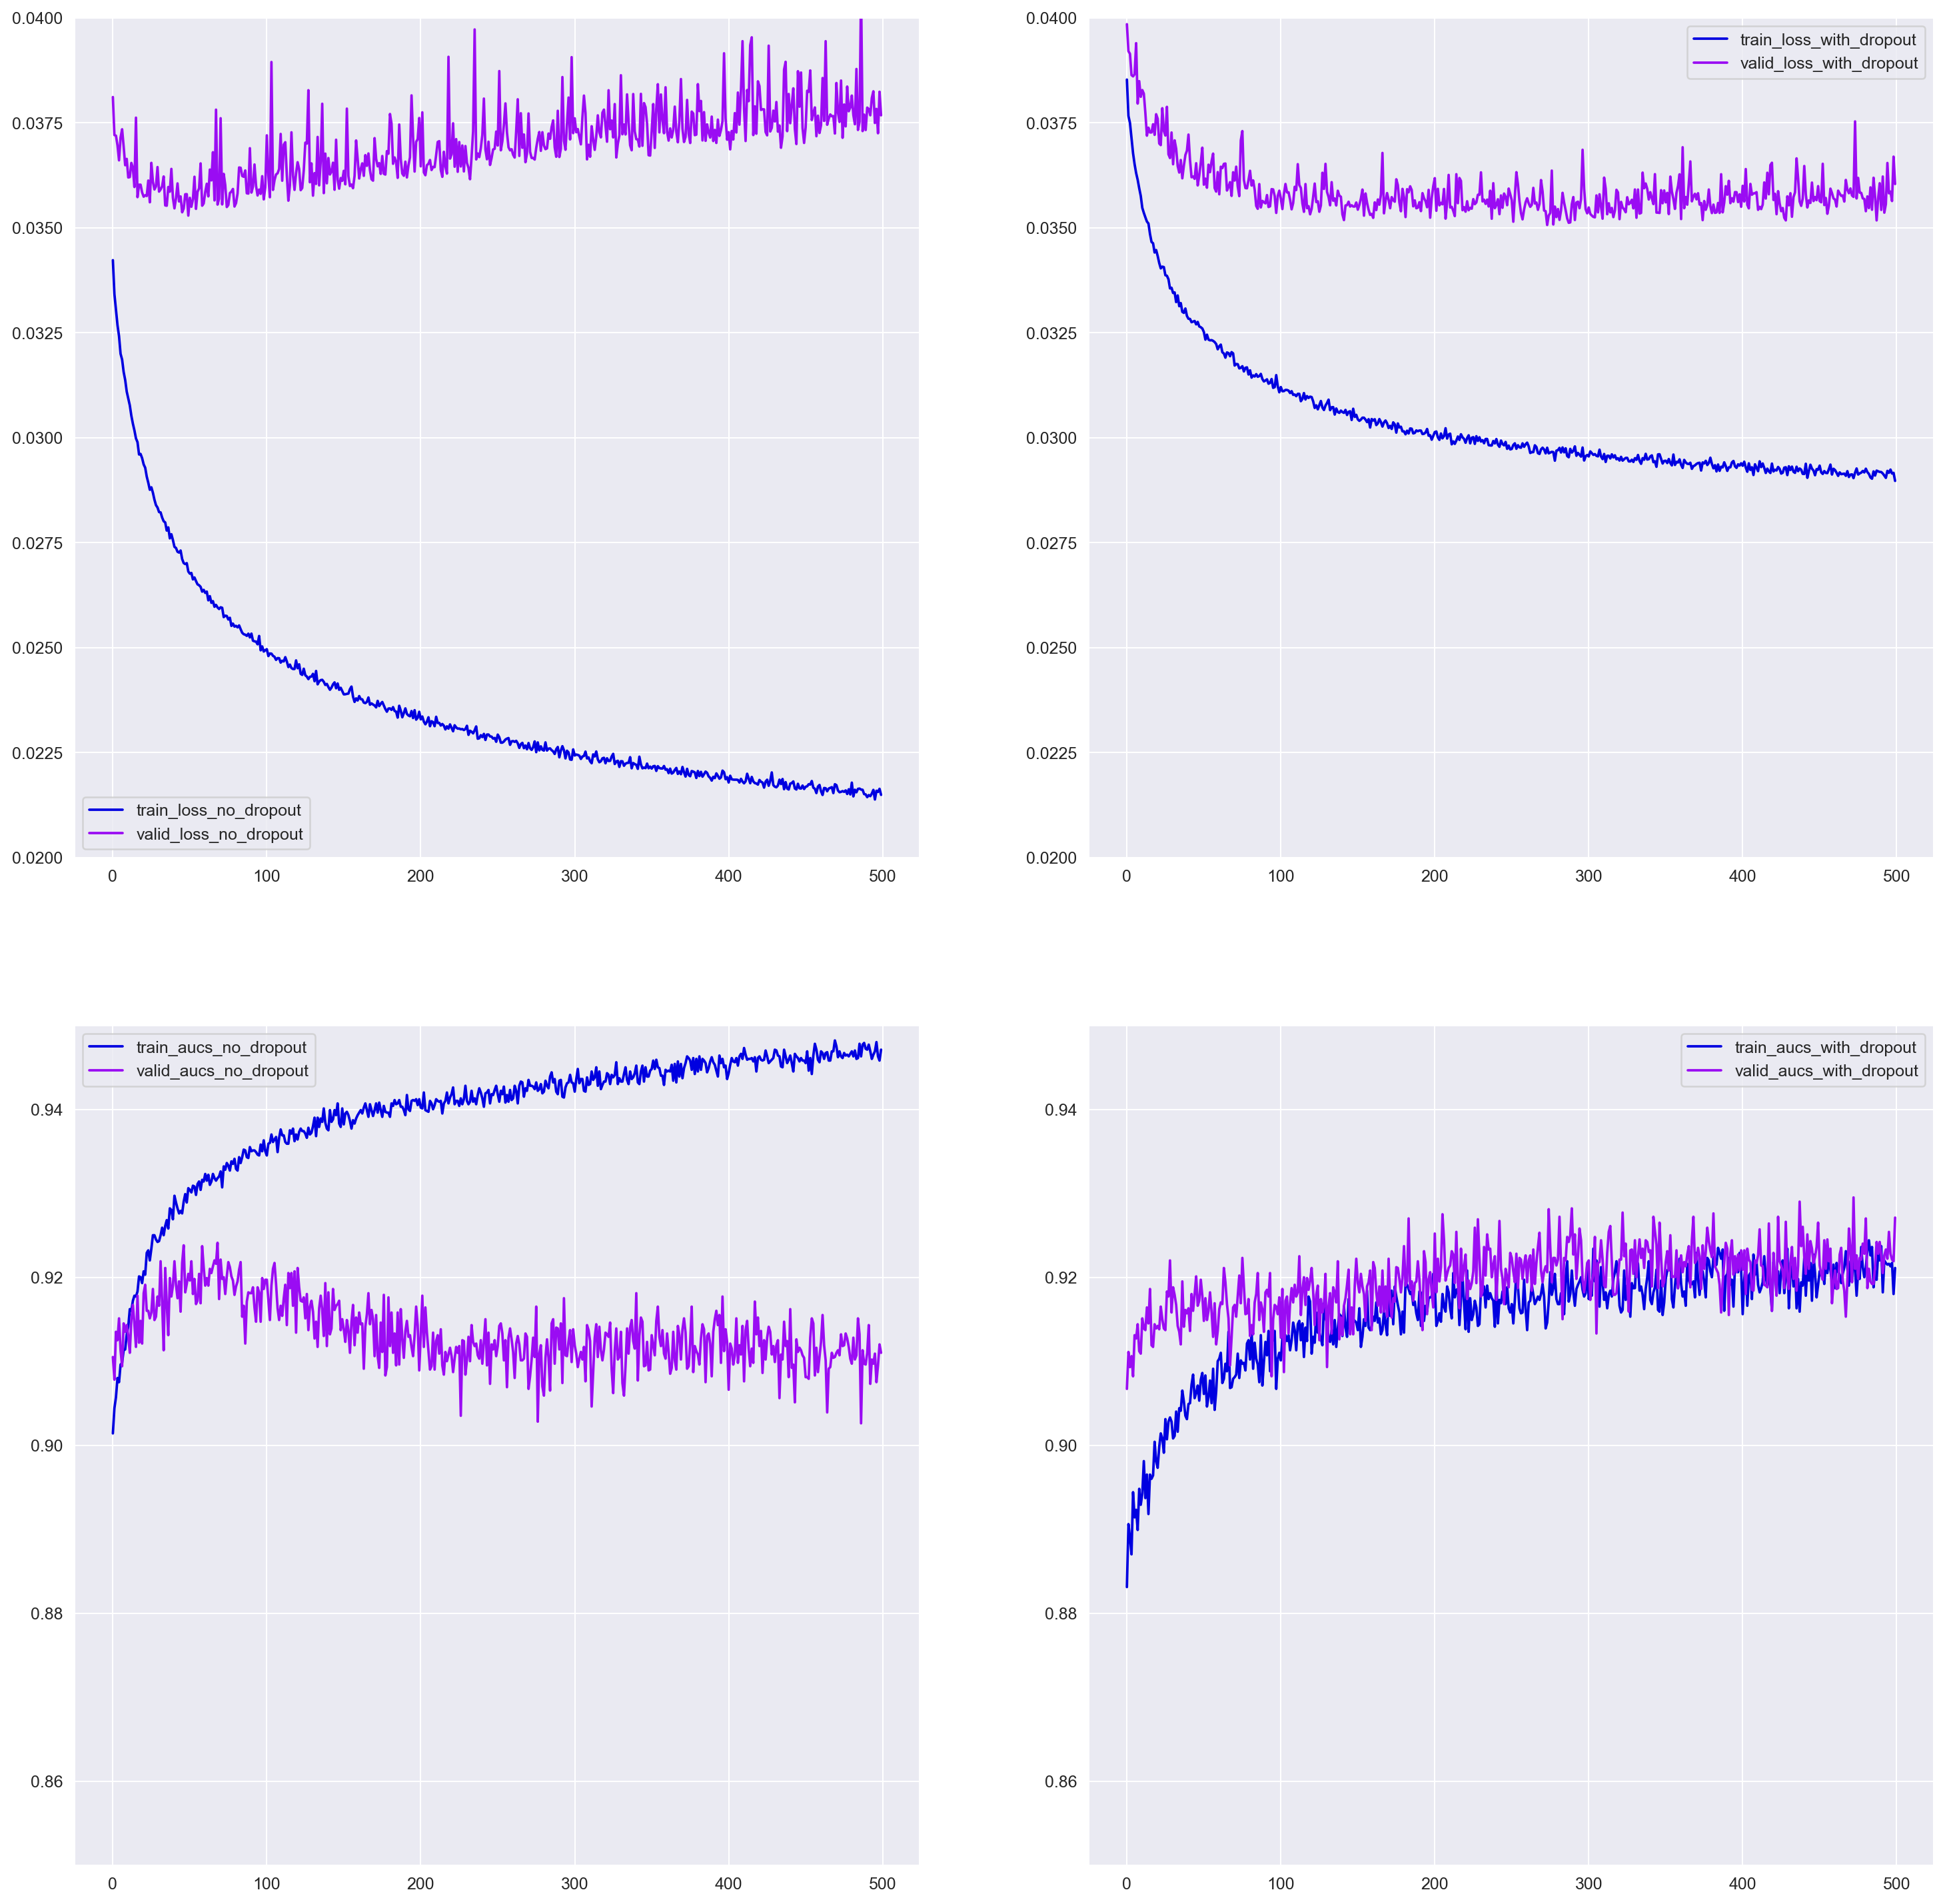

In [139]:
plot_fold(5)